# Beamforming with a cartesian grid and a polar grid

In this notebook, we will demonstrate how you can do beamforming with `zea` using a cartesian grid and a polar grid. We will use the `ScanConvert` to convert the polar data to cartesian data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/polar_grid.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/polar_grid.ipynb)

In [1]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["ZEA_DISABLE_CACHE"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import zea
from zea import ops
from zea.beamform.delays import compute_t0_delays_focused
from zea.beamform.phantoms import fish
from zea.probes import Probe
from zea.scan import Scan
from zea.visualize import pad_or_crop_extent, set_mpl_style

zea.init_device(verbose=False)
set_mpl_style()

zea: Using backend 'jax'


E0000 00:00:1752739728.747031  674733 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752739728.752641  674733 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752739728.767638  674733 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752739728.767654  674733 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752739728.767657  674733 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752739728.767658  674733 computation_placer.cc:177] computation placer already registered. Please check linka

## Define `zea.Probe` and `zea.Scan`

Let's initialize a linear ultrasound probe.

In [4]:
n_el = 128
aperture = 30e-3
probe_geometry = np.stack(
    [
        np.linspace(-aperture / 2, aperture / 2, n_el),
        np.zeros(n_el),
        np.zeros(n_el),
    ],
    axis=1,
)

probe = Probe(
    probe_geometry=probe_geometry,
    center_frequency=2.5e6,
    sampling_frequency=10e6,
)

We will use a focused scan for this example.

In [5]:
sound_speed = 1540.0
n_tx = 8

tx_apodizations = np.ones((n_tx, probe.n_el)) * np.hanning(probe.n_el)[None]
angles = np.linspace(30, -30, n_tx) * np.pi / 180
focus_distances = np.ones(n_tx) * 15e-3
t0_delays = compute_t0_delays_focused(
    origins=np.zeros((n_tx, 3)),
    focus_distances=focus_distances,
    probe_geometry=probe.probe_geometry,
    polar_angles=angles,
    sound_speed=sound_speed,
)

scan = Scan(
    n_el=n_el,
    center_frequency=probe.center_frequency,
    sampling_frequency=probe.sampling_frequency,
    probe_geometry=probe.probe_geometry,
    t0_delays=t0_delays,
    tx_apodizations=tx_apodizations,
    focus_distances=focus_distances,
    polar_angles=angles,
    initial_times=np.ones(n_tx) * 1e-6,
    n_ax=1024,
    lens_sound_speed=1000,
    lens_thickness=1e-3,
    sound_speed=sound_speed,
    xlims=(-20e-3, 20e-3),
    zlims=(0, 35e-3),
    n_tx=n_tx,
    n_ch=1,
)

Finally we initialize a scatterer phantom.

In [6]:
# Initialize the fish phantom
scat_positions = fish()
n_scat = scat_positions.shape[0]
simulation_parameters = dict(
    scatterer_positions=scat_positions.astype(np.float32),
    scatterer_magnitudes=np.ones(n_scat, dtype=np.float32),
)

## Initialize the pipeline

We initialize the default beamforming pipeline and prepend the simulator as the first operation.
Finally, we normalize the beamformed data to [0, 255] range for visualization purposes.

In [7]:
pipeline = ops.Pipeline.from_default()
pipeline.prepend(ops.Simulate())
pipeline.append(ops.Normalize(input_range=ops.DEFAULT_DYNAMIC_RANGE, output_range=(0, 255)))

## Beamforming with a cartesian grid

In [8]:
# Prepare parameters for the pipeline
scan.grid_type = "cartesian"  # cartesian grid is the default
parameters = pipeline.prepare_parameters(probe, scan)

# Run the pipeline
image_cart = pipeline(**parameters, **simulation_parameters)["data"][0]

# Define the extent for the cartesian grid
extent_cart = [*scan.xlims, *scan.zlims]

zea: Caching is globally disabled for compute_pfield.
zea: Computing pressure field for all transmits
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/transmits


## Beamforming with a polar grid

We add the scan convert operation to the pipeline because we will now use a polar grid.

In [ ]:
# Append ScanConvert to the pipeline
pipeline_sc = pipeline.copy()
pipeline_sc.append(ops.ScanConvert(order=3))
pipeline_sc.append(zea.keras.ops.Clip(0, 255))

# Prepare parameters for the pipeline
scan.grid_type = "polar"  # update grid type to polar
parameters = pipeline_sc.prepare_parameters(probe, scan)

image_polar = pipeline_sc(**parameters, **simulation_parameters)["data"][0]

# Define the extent for the polar grid
radius = scan.zlims[1]
xlims = (
    radius * np.cos(-np.pi / 2 + scan.theta_range[0]),
    radius * np.cos(-np.pi / 2 + scan.theta_range[1]),
)
extent_polar = [*xlims, *scan.zlims]

zea: WARNING GPU support for order > 1 is not available. Disabling jit for ScanConvert.
zea: Caching is globally disabled for compute_pfield.
zea: Computing pressure field for all transmits
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/transmits


## Visualize the beamformed data

Let's put the images side by side to compare the beamformed data on a
cartesian grid and a polar grid.

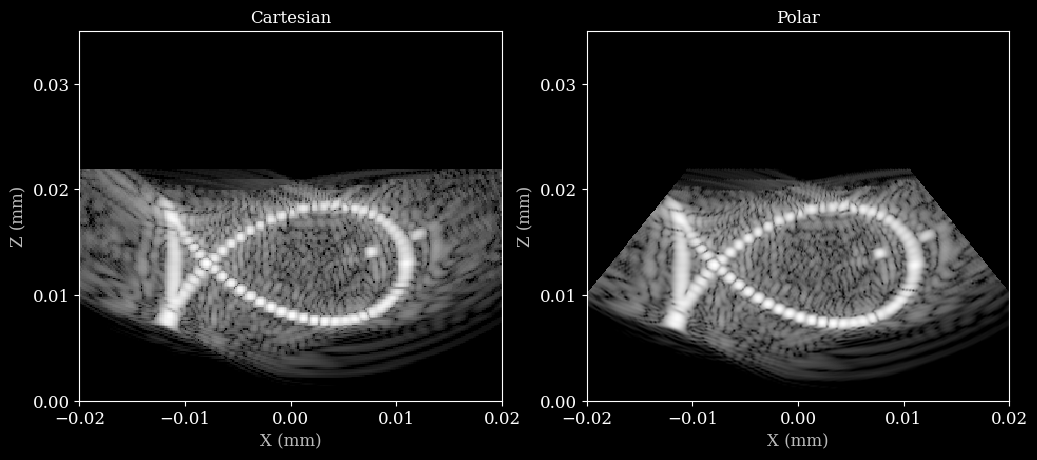

In [10]:
# Make sure the polar image has the same extent as the cartesian image
image_polar_corrected = pad_or_crop_extent(image_polar, extent_polar, extent_cart)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_cart, cmap="gray", extent=extent_cart, vmin=0, vmax=255)
axs[0].set_xlabel("X (mm)")
axs[0].set_ylabel("Z (mm)")
axs[0].set_title("Cartesian")
axs[0].locator_params(nbins=4)

axs[1].imshow(image_polar_corrected, cmap="gray", extent=extent_cart, vmin=0, vmax=255)
axs[1].set_title("Polar")
axs[1].set_xlabel("X (mm)")
axs[1].set_ylabel("Z (mm)")
axs[1].locator_params(nbins=4)